# Модуль интегрирования

## Реализация
Задача состоит в реализации методов численного интегрирования и проверку точности. Будем работат с одной из формул Ньютона-Котеса -- правилом трапеций.

Напомним, что в общем случае семейство формул Ньютона-Котеса есть линейная комбинация $f_i$, где -- $f_i$ -- значения рассматриваемой функции $f$ в $\{x_i\}$ -- точках разбиения рассматриваемого отрезка $[a; b]$.

Правило трапеций заключается в том, что на отрезке разбивения $[x_k; x_{k+1}]$ вычисляется следующее выражение, подобное формуле площади трапеции:
$$I'(x_k, x_{k+1})=\frac{x_{k+1} - x_{k}}{2}\cdot(f(x_k)+f(x_{k+1}))$$

После этого значение интеграла вычисляется как сумма таких "площадей" по всем отрезками разбиения, и можно заметить, что это в самом деле получается формула из упомянутого семейства.
$$I=\sum_{a\leqslant x_k<x_{k+1}\leqslant b}I'(x_k, x_{k+1})$$

Реализуем данную функцию.

In [1]:
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def rec_rule(f, grid):
    left = grid[:-1]
    right = grid[1:]
    f_v = np.vectorize(f, otypes=[float])
    return np.sum((right - left) * f_v((left + right) / 2))


def trap_rule(f, grid):
    left = grid[:-1]
    right = grid[1:]
    f_v = np.vectorize(f, otypes=[float])
    return np.sum((right - left) * (f_v(left) + f_v(right)) / 2)
        

## Оценка ошибок -- "хитрый подход"
Рассмотрим отрезок $[-1, 1]$ и функции, которые различаются на гладкие, разрывные и осциллирующие на этом отрезке:
1. $f(x)=-1/(x+2) + 2$
2. $g(x)=\begin{cases}5x^4 - 4, & x < 0\\1-x, & \text{иначе}\end{cases}$
3. $h(x)=\sin{500x}$

Будем оценивать ошибку интегрирования, а затем построем ее зависимость от величины шага (или размера разбиения).

Сначала сделаем так: найдум значение интеграла на отрезке с помощью встроенного решения, будем считать его за "идеальное". Затем построим график зависимости модуля разности этого "идеального" значения и вычисленного от размера разбиения. Прологарифмируем оси, чтобы видеть более полезную информацию.

Знаем, что если разбиение имеет шаг $h=(b-a)/N$, то если $I=I_h+O(h^p)=I_h+O(1/N^p)$, где $I$ -- истинный интеграл с шагом $h$, $I_h$ -- вычисленный, $p=3$ -- константа для метода трапеций -- порядок приближения.

In [3]:
def f(x):
    return -1 / (x + 2) + 2

def g(x):
    return 1 - x if x >= 0 else 5 * x ** 4 - 4

def h(x):
    return np.sin(500 * x)

range_counts = [10 ** i for i in range(1, 6)]
labels = ['f(x)', 'g(x)', 'h(x)']
functions = [f, g, h]
A = -1
B = 1

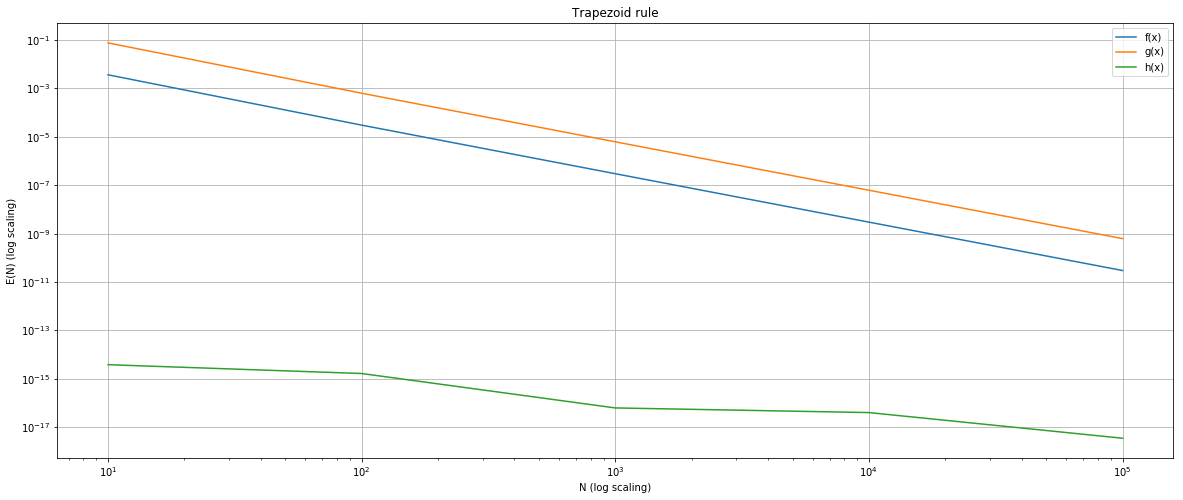

In [4]:
plt.figure(figsize=(20, 8))

for func, label in zip(functions, labels):
    real = si.quad(func, A, B)[0]
    result = []
    for i in range(len(range_counts)):
        result.append(
            np.abs(
                real - trap_rule(func, np.linspace(A, B, range_counts[i]))
            ))
    plt.plot(range_counts, result, label=label)

plt.grid(True)
plt.title('Trapezoid rule')
plt.xlabel('N (log scaling)')
plt.ylabel('E(N) (log scaling)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


## Оценка ошибок (правило Рунге)
Теперь будем вычислять ошибку с помощью правила Рунге, более частным способом, найдем ее оценку сверху:

$$|I-I_h|\leqslant\frac{|I_{h/2}-I_h|}{2^{p-1}-1}$$
где $p=3$ (для метода трапеций точность приближения: $p=3$).

То есть теперь мы на каждом отрезке вместо модуля разности будем считать верхнюю оценку, вычисляя интегралы с шагами $h$ и $h/2$ (т.е. размеры сеток на $N$ и $2N$ соответственно). Аналогично прологарифмируем оси.

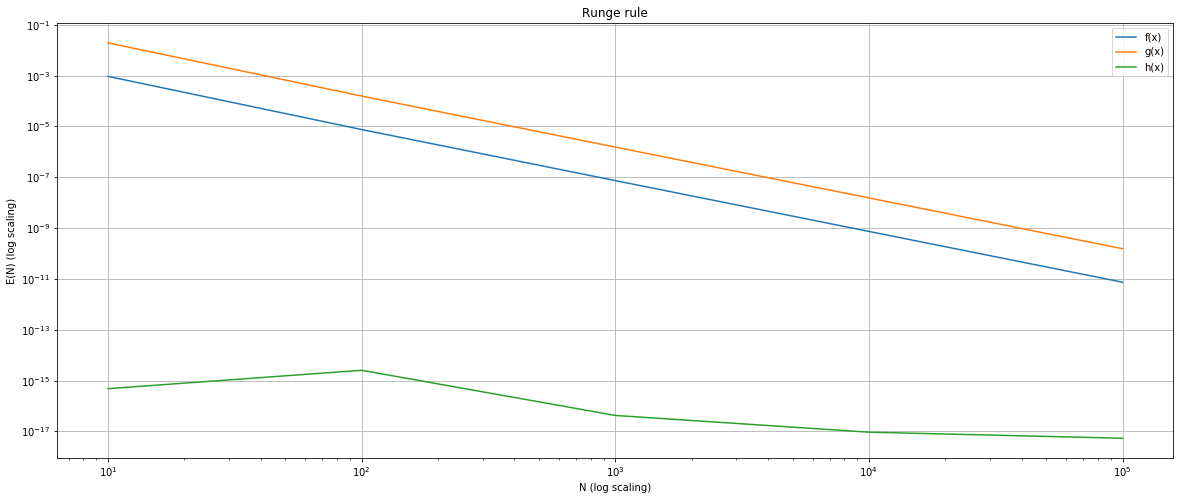

In [5]:
plt.figure(figsize=(20, 8))

for func, label in zip(functions, labels):
    result = []
    for i in range(len(range_counts)):
        result.append(
            np.abs(
                trap_rule(func, np.linspace(A, B, range_counts[i])) 
                          - trap_rule(func, np.linspace(A, B, range_counts[i] * 2))) / 3.
            )
    plt.plot(range_counts, result, label=label)
            
plt.grid(True)
plt.title('Runge rule')
plt.xlabel('N (log scaling)')
plt.ylabel('E(N) (log scaling)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()